# Approach quick check

I want to run through the process end to end and see if everything is working before porting it onto aws and running it. First I am going to check the database by pulling out the data into a feasible run format and take a quick look at it. 

# Imports

In [1]:
import sqlite3
import numpy as np
import io
import pandas as pd
import curve_manip as cm
import os 
import glob
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from IPython.display import clear_output
from sklearn.model_selection import KFold

Using TensorFlow backend.
C:\Users\cogillsb\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cogillsb\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cogillsb\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

# Connect to the database

In [2]:
def adapt_array(arr):
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)
conn = sqlite3.connect('HRM_syang.sqlite', detect_types=sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

# Building the matrices

I can grab all the data from the sequences table. I use an ordinal encoding process (easier than one hot) and I use the IUPAC single letter codes for the swing bases. A pretty simple sql join brings everything together and then I can just convert everything to numpy arrays. 

In [3]:
#Convert the sequences to numpy vectors
base_enc = {
    'A':0.25,
    'T':0.5,
    'C':0.75,
    'G':1.0,
    'N':(0.25 + 0.5 + 0.75 + 1.00)/4,
    'M':(0.75 + 0.25)/2,
    'Y':(0.5 + 0.75)/2,
    'X':(0.25 + 0.5 + 0.75 + 1.00)/4,
    '-':0.0,
    'S':(1.0 + 0.75)/2  
}

sql_command = """
SELECT raw_sequences.org_id, aligned_sequences.sequence, curves.norm_curve
FROM curves
INNER JOIN raw_sequences ON aligned_sequences.seq_id=raw_sequences.id
INNER JOIN aligned_sequences ON curves.seq_id=aligned_sequences.seq_id;
"""
curve_mat = []
seq_mat = []
tag_mat = []
cur.execute(sql_command)
data = cur.fetchall()
for d in data:
    curve_mat.append(d[2])
    seq_mat.append([base_enc[base] for base in d[1]])
    tag_mat.append(d[0])
curve_mat = np.array(curve_mat)/100
seq_mat = np.array(seq_mat)
tag_mat = np.array(tag_mat)


In [4]:
seq_mat.shape

(34, 213)

# Testing the gan

The data format looks great. Now I can see if it is compatible with a previous vesion of my gan script. 

Testing ACBA


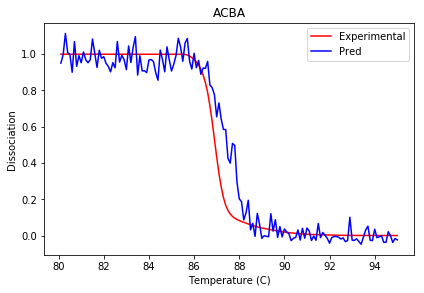

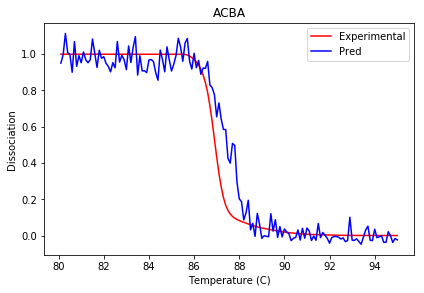

Testing ACHA


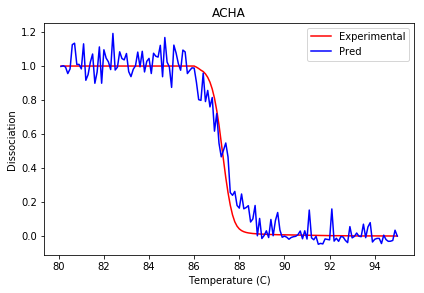

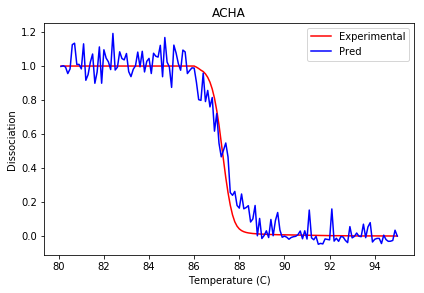

Testing ACJO


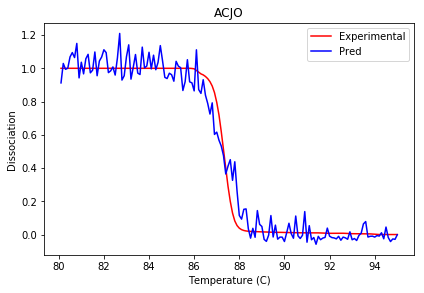

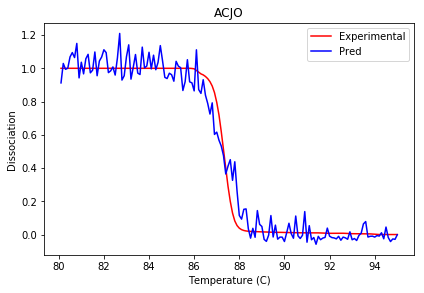

Testing ACLW


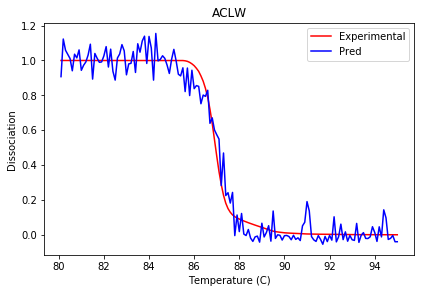

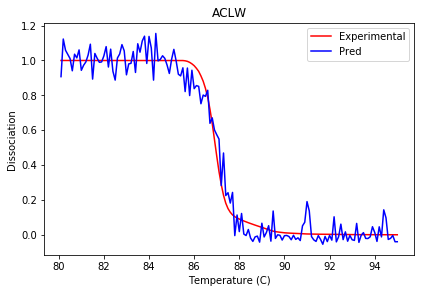

Testing AECA


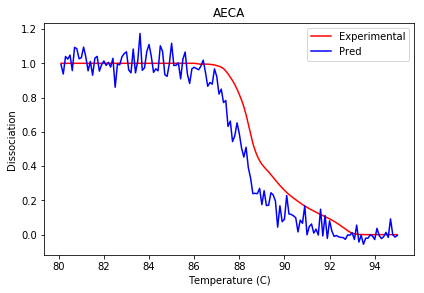

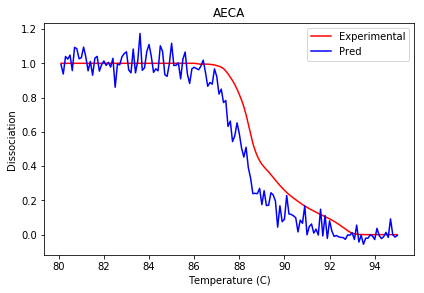

Testing AEUR


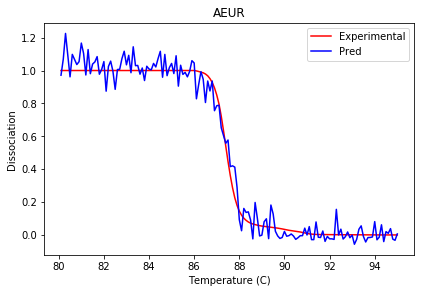

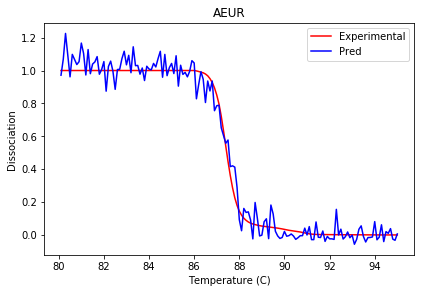

Testing AEVI


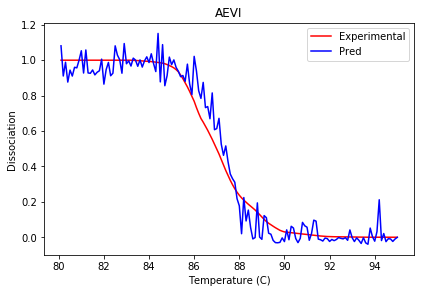

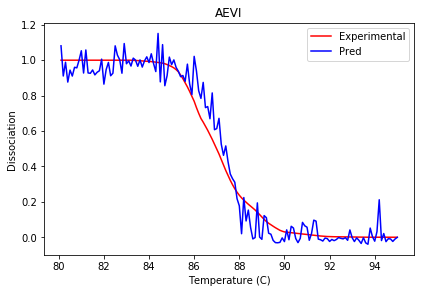

Testing BAAN


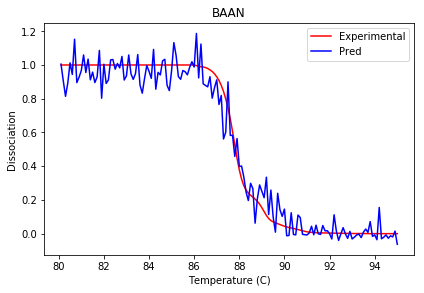

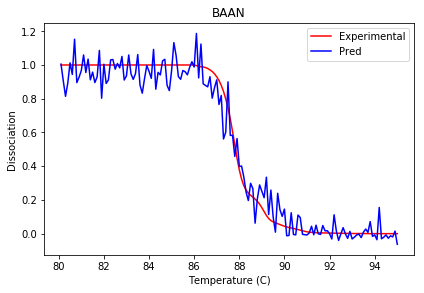

Testing BMYC


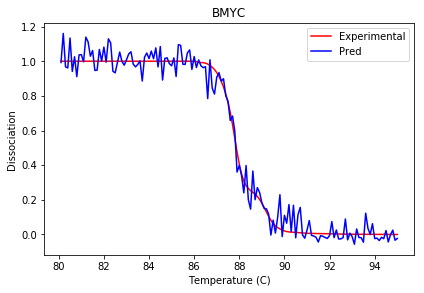

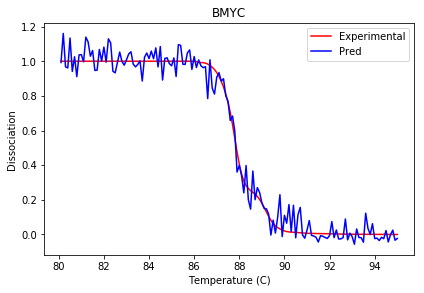

Testing BOPE


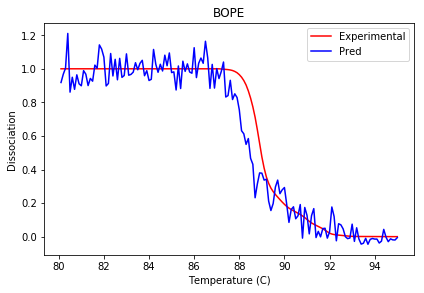

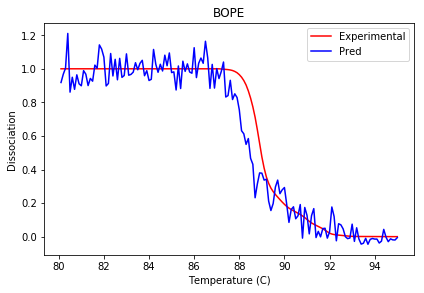

Testing BT


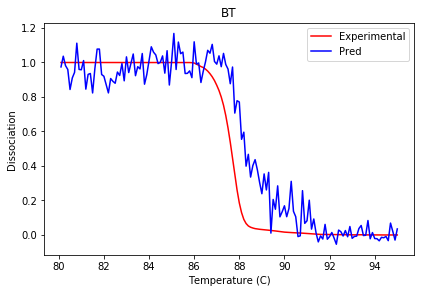

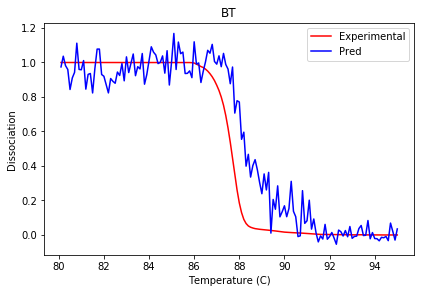

Testing BUPS


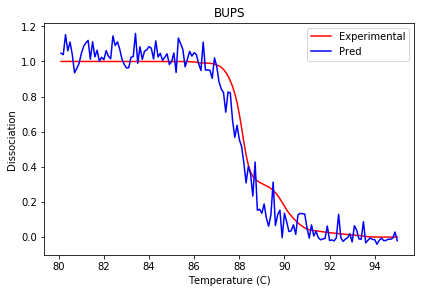

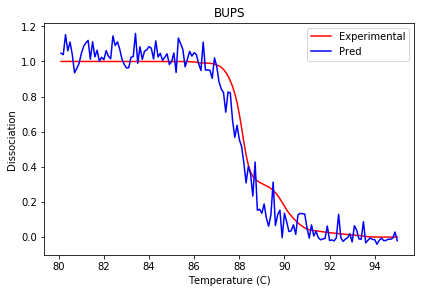

Testing CPN


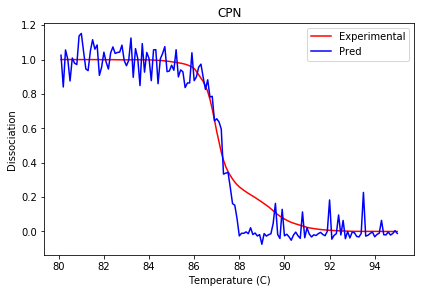

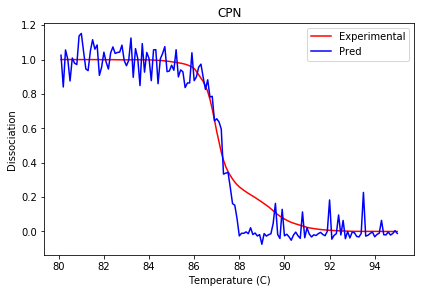

Testing CT


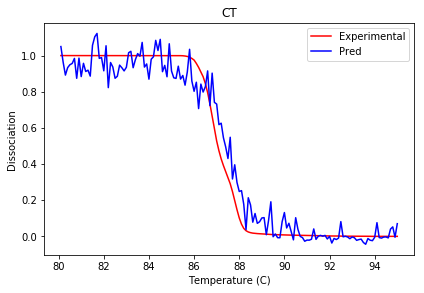

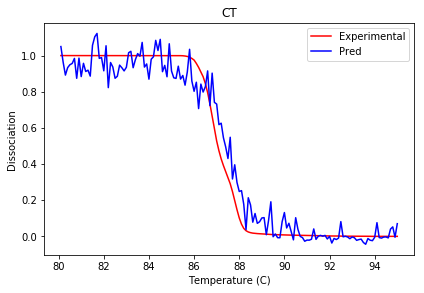

Testing EFAEC


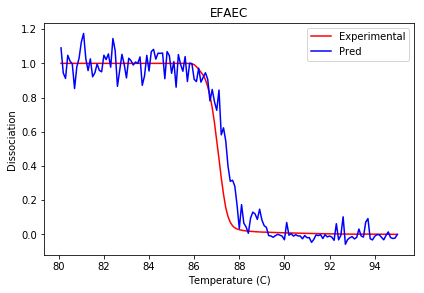

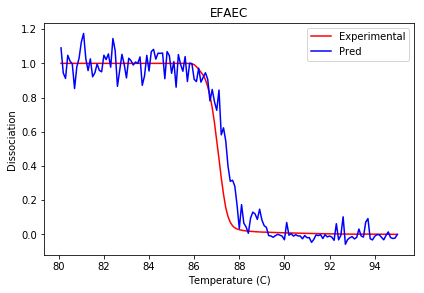

Testing EICO


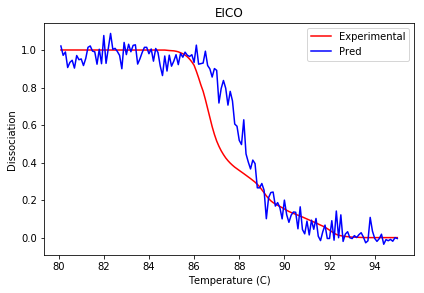

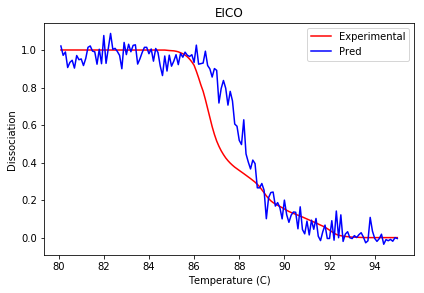

Testing ENAG


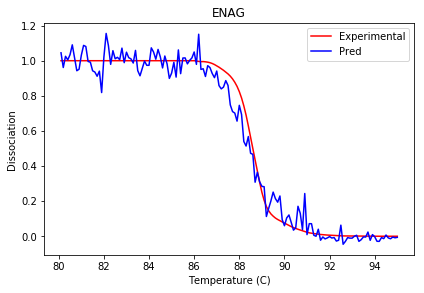

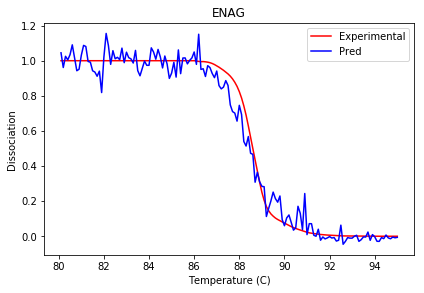

Testing ENCL


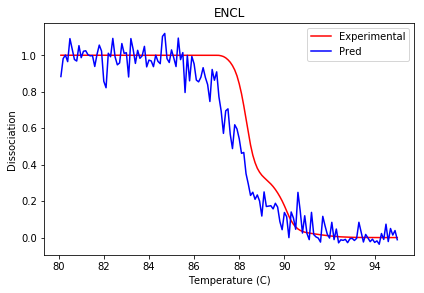

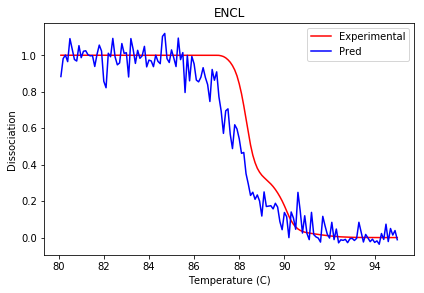

Testing ESCO


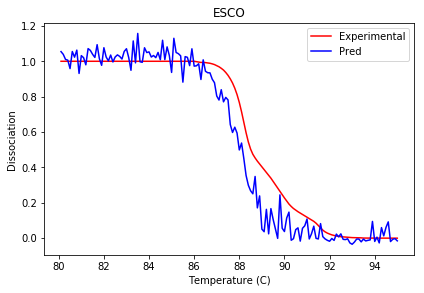

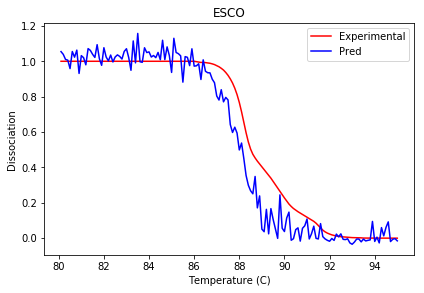

Testing FRTU


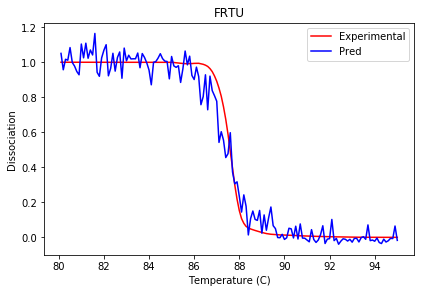

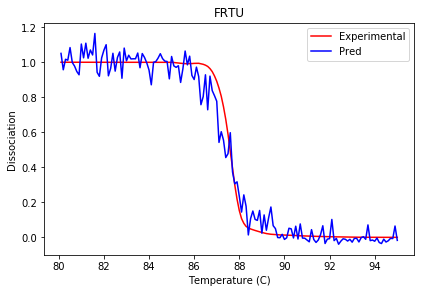

Testing FUNU


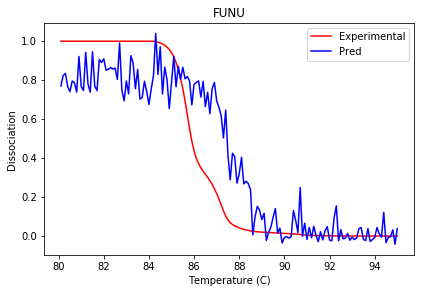

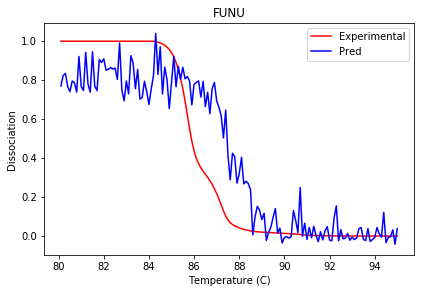

Testing HAIN


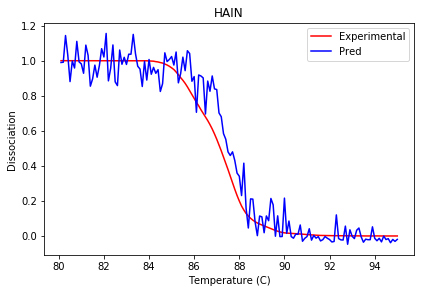

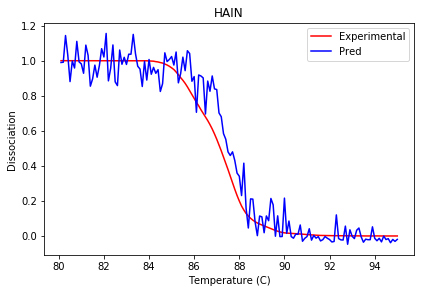

Testing KLOX


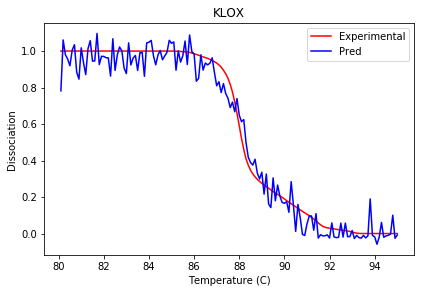

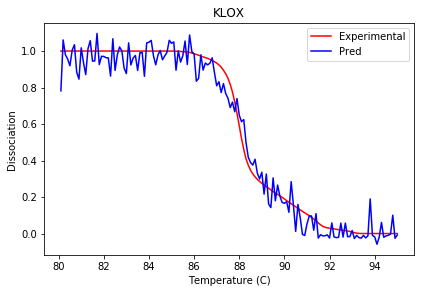

Testing KLPN


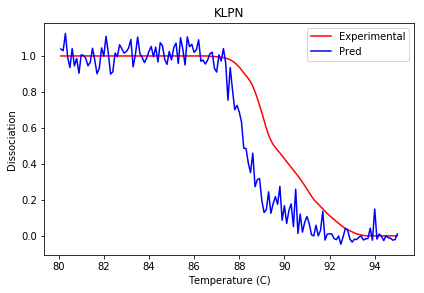

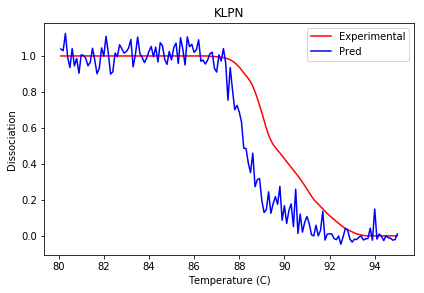

Testing MOMO


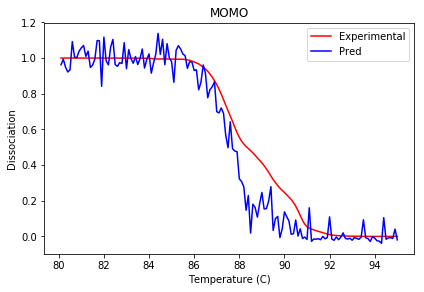

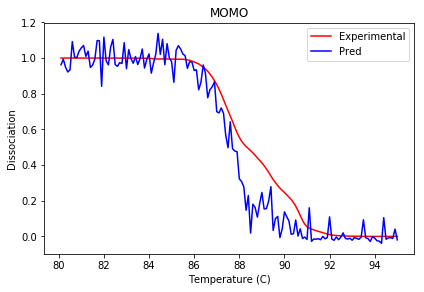

Testing MYHO


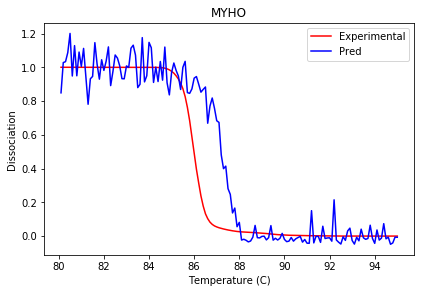

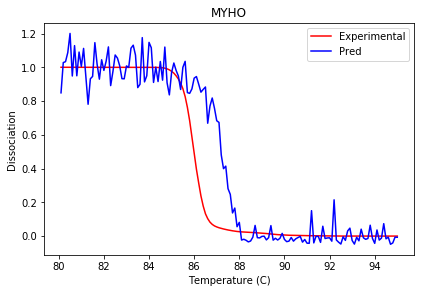

Testing NEME


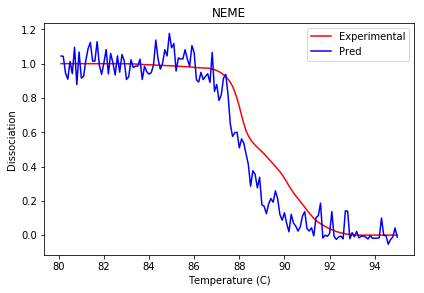

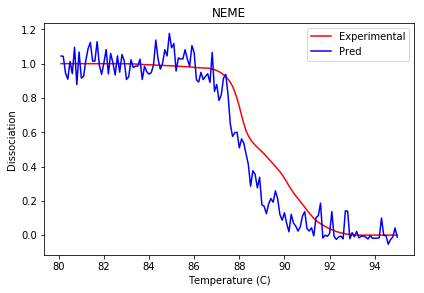

Testing PAMU


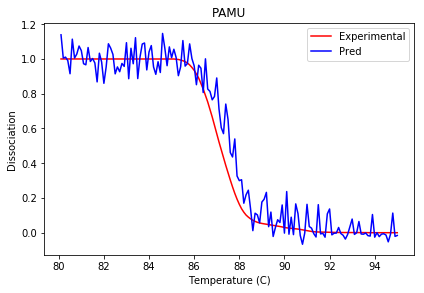

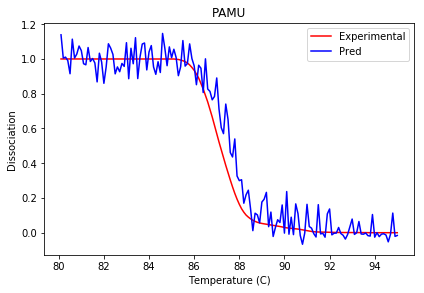

Testing PRRE


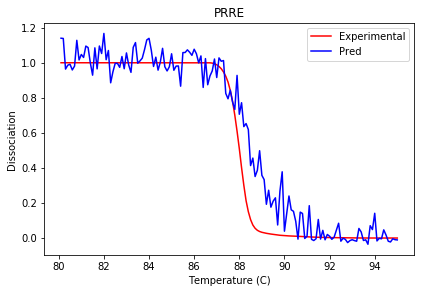

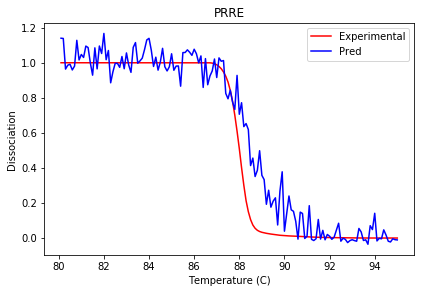

Testing SAHE


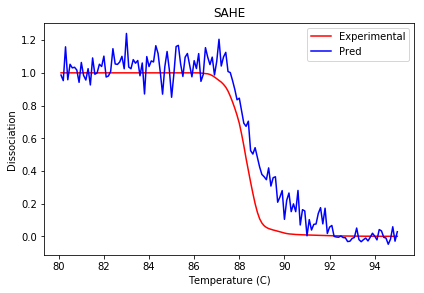

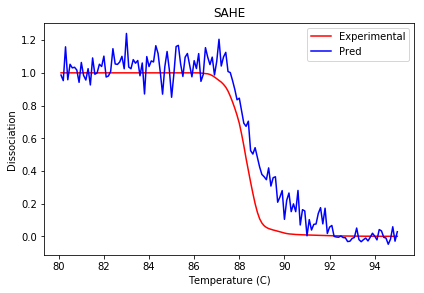

Testing SELI


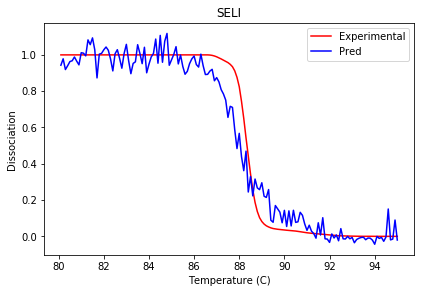

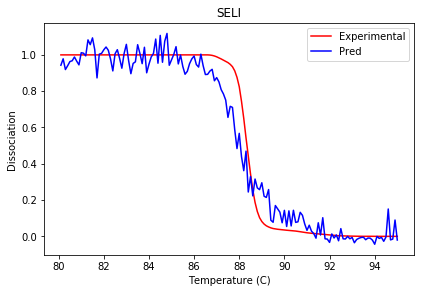

Testing SHFL


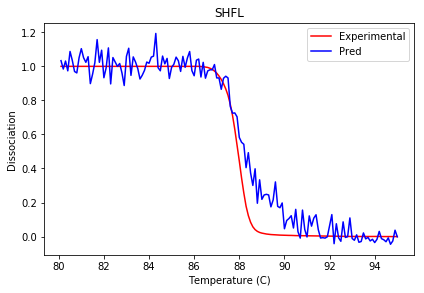

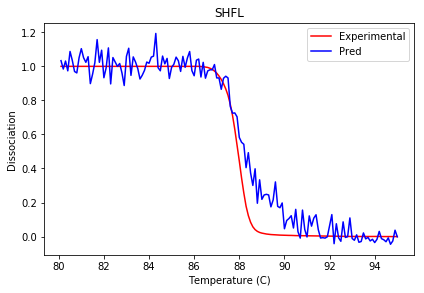

Testing STHO


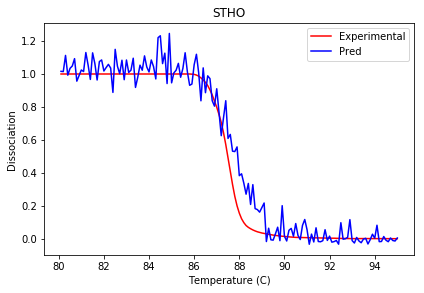

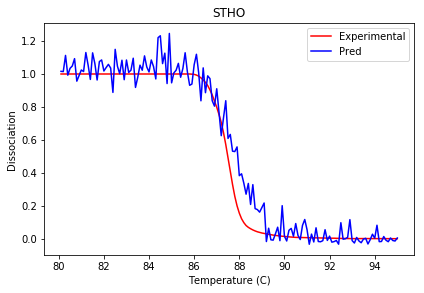

In [6]:
def output_plt(seqs, curves, ids, generator):
    '''
    plot out the data
    '''
    for i in range(0,len(curves)):
        
        #Plot the actual curve
        plt.plot(np.arange(80.1,95.0,0.1), curves[i], label='Experimental',color='red')

        #Plot the pred_curve
        gen_images = generator.predict([np.array([seqs[i]])])
        plt.plot(np.arange(80.1,95.0,0.1), gen_images[0], label='Pred',color='blue')
        
        
        #Show the plot
        plt.ylabel('Dissociation')
        plt.legend(loc="upper right")
        plt.xlabel('Temperature (C)')
        plt.ylabel('Dissociation')    
        plt.tight_layout()
        plt.title('%s' % ids[i])
        plt.show()
        


def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def build_generator():
    seq_input = Input(shape = (213,))
    first = Dense(256)(seq_input)
    first = LeakyReLU(0.2)(first)
    
    second = Dense(512)(first)
    second = LeakyReLU(0.2)(second)
    
    third = Dense(1028)(second)
    third = LeakyReLU(.2)(third)
    
    out = Dense(150)(third)
    out = LeakyReLU(.2)(out)
    
    gen = Model([seq_input,], out)
    gen.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    
    return gen

    
def build_discriminator():
    curve_input = Input(shape = (150,))
    seq_input = Input(shape = (213,))
    dis_input = concatenate([curve_input, seq_input])
    first = Dense(1028)(dis_input)
    first = LeakyReLU(0.2)(first)
    
    second = Dense(512)(first)
    second = LeakyReLU(0.2)(second)
    
    third = Dense(256)(second)
    third = LeakyReLU(.2)(third)
    
    out = Dense(1, activation='sigmoid')(third)
    
    dis = Model([curve_input, seq_input,], out)
    
    dis.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    
    return dis

def build_gan(discriminator, generator):
    
    discriminator.trainable=False
    
    gan_input = Input(shape=(213,))
    
    x = generator(gan_input)
    
    gan_output= discriminator([x, gan_input])
    
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    
    return gan

#Load the data
seqs = seq_mat
curves = curve_mat
ids = tag_mat

#Split the data for a loocv
kf = KFold(n_splits=len(curves))

#Run each fold
for train_index, test_index in kf.split(seqs):
    
    #Split the matrices
    seqs_train, seqs_test = seqs[train_index], seqs[test_index]
    curves_train, curves_test = curves[train_index], curves[test_index]
    ids_train, ids_test = ids[train_index], ids[test_index]
    
    print('Testing %s' % str(ids_test[0]))
    
    # Creating GAN
    generator= build_generator()
    discriminator= build_discriminator()
    gan = build_gan(discriminator, generator)
    

    for e in range(300):
        #Predict curves
        gen_images = generator.predict([seqs_train])

        #Train the discriminator
        #Label real curves
        y_rl = np.random.uniform(low=0.7, high=1.0, size=(len(seqs_train)))
        

        #Turn on the discriminator
        discriminator.trainable = True

        #Train on real curves
        dloss = discriminator.train_on_batch([curves_train, seqs_train], y_rl)

        # Label fake curves
        y_fk = np.random.uniform(low=0.0, high=0.3, size=(len(seqs_train)))

        #Train on fake curves
        dloss = discriminator.train_on_batch([gen_images,  seqs_train], y_fk)
                                              

        #Train the generator
        #Turn off the discriminator
        discriminator.trainable = False

        #Train on fake curves
        gloss = gan.train_on_batch([seqs_train], y_rl)
        
    output_plt(seqs_test, curves_test, ids_test, generator) 
            

    #plt results
    output_plt(seqs_test, curves_test, ids_test, generator) 
    



# Conclusion

This looks like it is ready to go on a gpu for testing. 